# Categorical

## 1 Dimension
- converges
- drops to zero

## Multi Dimension
- dimension = 3, plugin does worse (hopefully)
- dimension = 40 still converges
- drops to 0?
- convergence rate

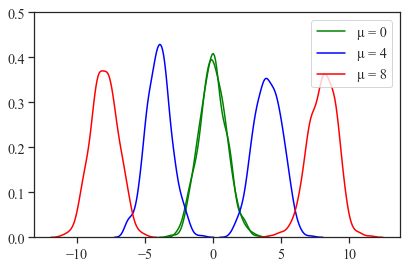

In [64]:
import numpy as np
%matplotlib inline

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)
sns.set_style("ticks")


def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(1000, 2, 1)
sample = list(zip(X, y))
class_two, class_neg_two = split_by_class(sample)

X, y = get_sample(1000, 4, 1)
sample = list(zip(X, y))
class_four, class_neg_four = split_by_class(sample)

X, y = get_sample(1000, 0, 1)
sample = list(zip(X, y))
class_zero, class_neg_zero = split_by_class(sample)

X, y = get_sample(1000, 8, 1)
sample = list(zip(X, y))
class_eight, class_neg_eight = split_by_class(sample)

plt.figure()
plt.rcParams["font.family"] = "Times New Roman"

sns.distplot(list(zip(*class_zero))[0], hist=False, color = "green", label = u'\u03bc = 0')
sns.distplot(list(zip(*class_neg_zero))[0], hist=False, color = "green")

sns.distplot(list(zip(*class_four))[0], hist=False, color = "blue", label = u'\u03bc = 4')
sns.distplot(list(zip(*class_neg_four))[0], hist=False, color = "blue")
plt.tight_layout()
sns.distplot(list(zip(*class_eight))[0], hist=False, color = "red", label = u'\u03bc = 8')
sns.distplot(list(zip(*class_neg_eight))[0], hist=False, color = "red")
plt.ylim(ymax = .5)
plt.legend()
plt.savefig("1d_setting.png")
plt.show()


In [62]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = int(math.sqrt(X.shape[1]))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .32)


0.6810520458312763

In [24]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
import scipy.integrate as integrate
import math

from sklearn import mixture
X, y = get_sample(100000, 0, 1)
X = np.array(X).reshape(-1, 1)
def estimate_p(y):
    return y.count(1)/len(y)

def estimate_x_params(X):
    model = mixture.GaussianMixture(n_components = 2, covariance_type = "full")
    model.fit(X)
    return model.means_, model.covariances_
    
estimate_x_params(X)

def normal_entropy_f(t, mean, var):
    return -norm.pdf(t, mean, var)*np.log(norm.pdf(t, mean, var))

def two_mixture_normals_entropy_f(t, mean_1, mean_2, var_1, var_2):
    return -.5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2)) - .5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2))

def normal_entropy(var):
    return .5*np.log(2*math.pi*math.e*var)

#NOTE: this doesn't work for mean = 0
def plugin_estimate_cat_1D(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    #h_x_cond_y = integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][0], x_params[1][0].item()))[0]*.5 + \
    #integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][1], x_params[1][1].item()))[0]*.5
    h_x_cond_y = normal_entropy(x_params[1][0])*.5 + normal_entropy(x_params[1][1])*.5
    h_x = integrate.quad(two_mixture_normals_entropy_f, -20, 20, args = (x_params[0][0], x_params[0][1], x_params[1][0].item(), x_params[1][1].item()))[0]
    cond_entropy =  h_y - h_x + h_x_cond_y
    if cond_entropy < 0:
        return np.array((0))
    return cond_entropy


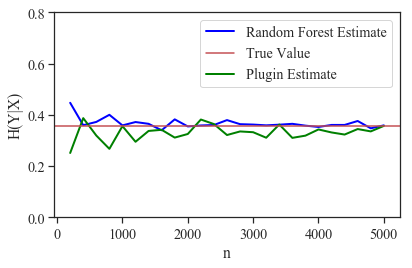

In [67]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    plugin_estimate = []
    sample_sizes = [i*200 for i in range(1, 26)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
        plugin_estimate.append(plugin_estimate_cat_1D(np.array(X).reshape(-1, 1), y).item())
    return sample_sizes, conditional_entropy, plugin_estimate


sample_sizes, cond_entropy, plugin_estimate = get_cond_entropy_vs_n(1)
#plt.scatter(sample_sizes, cond_entropy, marker = "None",)
#plt.scatter(sample_sizes, plugin_estimate, marker = "None")
sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_est, = plt.plot(sample_sizes, cond_entropy, label = "Random Forest Estimate", linewidth = 2, color = "blue")

line_plugin, = plt.plot(sample_sizes, plugin_estimate, label = "Plugin Estimate", linewidth = 2, color = "green")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "True Value")
plt.xlabel("n")
plt.ylabel("H(Y|X)")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.legend(handles=[line_est, line_true, line_plugin])
plt.tight_layout()
plt.savefig("cat_1d_mean1.png")
plt.show()

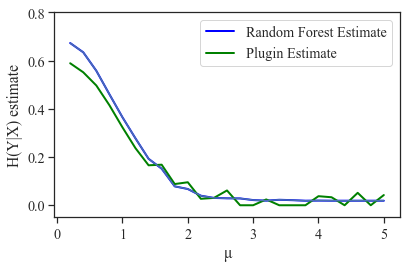

In [68]:
def get_cond_entropy_vs_mu(n):
    conditional_entropy = []
    plugin_estimate = []
    means = [i*.2 for i in range(1, 26)]
    for elem in tqdm_notebook(means):
        X, y = get_sample(n, elem, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
        plugin_estimate.append(plugin_estimate_cat_1D(np.array(X).reshape(-1, 1), y).item())
    return means, conditional_entropy, plugin_estimate

means, cond_entropy, plugin_estimate = get_cond_entropy_vs_mu(2000)

sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_est, = plt.plot(means, cond_entropy, label = "Random Forest Estimate", linewidth = 2, color = "blue")
line_plugin, = plt.plot(means, plugin_estimate, label = "Plugin Estimate", linewidth = 2, color = "green")
plt.plot(means, cond_entropy)
plt.ylim(ymin = -.05)
plt.ylim(ymax = .8)
plt.legend(handles=[line_est, line_plugin])
plt.xlabel(u'\u03bc')
plt.ylabel("H(Y|X) estimate")
plt.tight_layout()
plt.savefig("cat_1d_n2000_conv0.png")
plt.show()

# Multidimensional

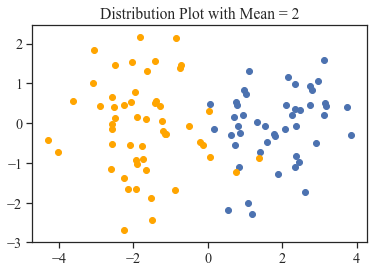

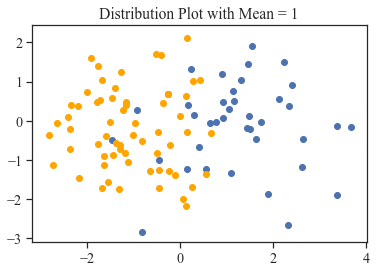

In [32]:
def get_multivariate_sample(n, d, mean):
    x_sample = []
    y_sample = []
    means = np.zeros(d)
    means[0] = mean
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.multivariate_normal(-means, np.identity(d))
        else:
            x = np.random.multivariate_normal(means, np.identity(d))
        x_sample.append(x.tolist())
        y_sample.append(y)
    return x_sample, y_sample

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_multivariate_sample(100, 2, 2)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 2")
plt.show()

X, y = get_multivariate_sample(100, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 1")
plt.show()


In [58]:
#def multi_normal_entropy(x1, x2, mean, covar):
#    return multivariate_normal.pdf([x1,x2], mean, covar)*np.log(multivariate_normal.pdf([x1,x2], mean, covar))

#integrate.nquad(multi_normal_entropy, [[-20, 20], [-20, 20]], args = (0, np.identity(2)))

def multivariate_normal_entropy(covar):
    covar = np.array(covar)
    dim = covar.shape[-1]
    return multivariate_normal(np.zeros(dim), covar).entropy()

def two_mixture_multivariate_normal_entropy_f(t1, t2, t3, mean_1, mean_2, covar_1, covar_2):
    t = (t1, t2, t3)
    return -multivariate_normal.pdf(t, mean_1, covar_1)*np.log(.5*multivariate_normal.pdf(t, mean_1, covar_1) + .5*multivariate_normal.pdf(t, mean_2, covar_2))

def two_mixture_multivariate_normal_entropy(mean_1, mean_2, covar_1, covar_2):
    dim = 1
    # to handle dimension errors
    try:
        dim = len(mean_1)
    except TypeError:
        pass
    bounds = [[-6, 6] for _ in range(dim)]
    return integrate.nquad(two_mixture_multivariate_normal_entropy_f, bounds, args = [mean_1, mean_2, covar_1, covar_2])

def plugin_estimate_cat_multi(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    print("integrating")
    h_y = (-y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param))
    h_x_cond_y = (multivariate_normal_entropy(x_params[1][0])*.5 + multivariate_normal_entropy(x_params[1][1])*.5)
    h_x = two_mixture_multivariate_normal_entropy(x_params[0][0], x_params[0][1], x_params[1][0], x_params[1][1])[0]
    cond_entropy = h_y - h_x + h_x_cond_y
    if cond_entropy < 0:
        return 0
    return cond_entropy

X, y = get_multivariate_sample(1000, 3, 1)
estimate_x_params(X)
plugin_estimate_cat_multi(X, y)

integrating


0.2902555085617302

integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating
integrating


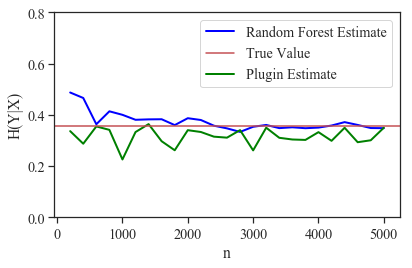

In [69]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n_d(mean, d):
    conditional_entropy = []
    plugin_estimate= []
    sample_sizes = [i*200 for i in range(1, 26)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 300, .32, depth = 30))
        plugin_estimate.append(plugin_estimate_cat_multi(X, y))
    return sample_sizes, conditional_entropy, plugin_estimate

sample_sizes, cond_entropy, plugin_estimate = get_cond_entropy_vs_n_d(1, 3)
sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_est, = plt.plot(sample_sizes, cond_entropy, label = "Random Forest Estimate", linewidth = 2, color = "blue")
line_plugin, = plt.plot(sample_sizes, plugin_estimate, label = "Plugin Estimate", linewidth = 2, color = "green")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "True Value")
plt.xlabel("n")
plt.ylabel("H(Y|X)")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.legend(handles=[line_est, line_true, line_plugin])
plt.tight_layout()
plt.savefig("cat_3d_mean1.png")
plt.show()

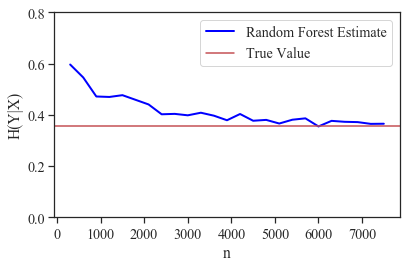

In [71]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n_d(mean, d):
    conditional_entropy = []
    plugin_estimate= []
    sample_sizes = [i*300 for i in range(1, 26)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_multivariate_sample(elem, d, mean)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X), y, 300, .32, depth = 30))
        #plugin_estimate.append(plugin_estimate_cat_multi(X, y))
    return sample_sizes, conditional_entropy, plugin_estimate

sample_sizes, cond_entropy, plugin_estimate = get_cond_entropy_vs_n_d(1, 40)
sns.set(font_scale = 1.3)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Times New Roman"
line_est, = plt.plot(sample_sizes, cond_entropy, label = "Random Forest Estimate", linewidth = 2, color = "blue")
#line_plugin, = plt.plot(sample_sizes, plugin_estimate, label = "Plugin Estimate", linewidth = 2, color = "green")
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "True Value")
plt.xlabel("n")
plt.ylabel("H(Y|X)")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.legend(handles=[line_est, line_true])
plt.tight_layout()
plt.savefig("cat_40d_mean1.png")
plt.show()